In [1]:
from common import *

### Load dataset

In [4]:
data_type_list = ['source_list', 'cam_param', 'cam_param_adaptive_focal',
                  'world_3d', 'cam_3d', 'img_2d', 
                  'img_3d', 'scale_factor', 'img_25d', 
                  'cam_3d_canonical_same_z', 'img_2d_canonical_same_z', 
                  'cam_3d_canonical_same_dist', 'img_2d_canonical_same_dist',
                  'cam_3d_canonical_fixed_dist_5', 'img_2d_canonical_fixed_dist_5', 'img_2d_canonical_fixed_dist_5_adaptive_focal'
                  ]
overwrite_list = []
dataset_name = 'h36m'
data = load_data_dict(dataset_name, data_type_list, overwrite_list, verbose=True)

[overwrite: False] ==> Loading H36M source_list...
[overwrite: False] ==> Loading H36M cam_param...
[overwrite: False] ==> Loading H36M cam_param_adaptive_focal...
[overwrite: False] ==> Loading H36M world_3d...
[overwrite: False] ==> Loading H36M cam_3d...
[overwrite: False] ==> Loading H36M img_2d...
[overwrite: False] ==> Loading H36M img_3d...
[overwrite: False] ==> Loading H36M scale_factor...
[overwrite: False] ==> Loading H36M img_25d...
[overwrite: False] ==> Loading H36M cam_3d_canonical_same_z...
[overwrite: False] ==> Loading H36M img_2d_canonical_same_z...
[overwrite: False] ==> Loading H36M cam_3d_canonical_same_dist...
[overwrite: False] ==> Loading H36M img_2d_canonical_same_dist...
[overwrite: False] ==> Loading H36M cam_3d_canonical_fixed_dist_5...
[overwrite: False] ==> Loading H36M img_2d_canonical_fixed_dist_5...
[overwrite: False] ==> Loading H36M img_2d_canonical_fixed_dist_5_adaptive_focal...


In [12]:
# with steprot
overwrite_list = [] # ['cam_3d', 'img_2d', 'cam_3d_canonical_same_z', 'img_2d_canonical_same_z']
data.update(load_data_dict(dataset_name, ['cam_3d', 'img_2d', 'cam_3d_canonical_same_z', 'img_2d_canonical_same_z'], overwrite_list, verbose=True, step_rot=0.5))

[overwrite: False] ==> Loading H36M cam_3d_steprot_0.5...


100%|██████████| 836/836 [00:05<00:00, 158.61it/s]


[overwrite: False] ==> Loading H36M img_2d_steprot_0.5...
/home/hrai/codes/MotionBERT/data/motion3d/h36m/h36m_cam_3d_steprot_0.5.pkl


100%|██████████| 836/836 [00:00<00:00, 911.44it/s] 


[overwrite: False] ==> Loading H36M cam_3d_canonical_same_z_steprot_0.5...


100%|██████████| 836/836 [00:02<00:00, 315.56it/s]


[overwrite: False] ==> Loading H36M img_2d_canonical_same_z_steprot_0.5...


100%|██████████| 836/836 [00:00<00:00, 957.41it/s] 


### Generate video from source

In [5]:
# select target
source_list = data['source_list'].copy()
shuffled = False
num_sources = 4
if shuffled: random.shuffle(source_list)
if num_sources > 0: target_list = source_list[:num_sources]
else: target_list = source_list 
len(target_list), target_list

(4,
 ['S1_54138969_Waiting 1',
  'S1_60457274_Waiting 1',
  'S1_55011271_Waiting 1',
  'S1_58860488_Waiting 1'])

In [12]:
# select datatype
data_type_3d = 'cam_3d_canonical_same_z_steprot_1'
data_type_2d = 'img_2d_steprot_1'
if data_type_3d != None and data_type_2d != None: data_type = f'{data_type_3d}+{data_type_2d}'
elif data_type_3d != None and data_type_2d == None: data_type = data_type_3d
elif data_type_3d == None and data_type_2d != None: data_type = data_type_2d

save_folder = f'/home/{user}/codes/MotionBERT/videos/{dataset_name}/{data_type}'
if not os.path.exists(save_folder): os.makedirs(save_folder)
else: print(f'{save_folder} already exists')

100%|██████████| 240/240 [00:08<00:00, 27.03it/s]


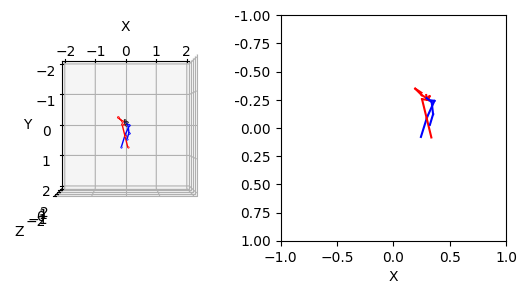

In [13]:
for source in target_list:
    subject, cam_id, action = split_source_name(source, dataset_name)
    save_path = os.path.join(save_folder, f'{subject}_{cam_id}_{action}.mp4')
    if os.path.exists(save_path): 
        print(f'{save_path} already exists')
        continue
    cam_param = data['cam_param'][subject][action][cam_id].copy()
    W, H, R, t, C, intrinsic, extrinsic = cam_param['W'], cam_param['H'], cam_param['R'], cam_param['t'], cam_param['C'], cam_param['intrinsic'], cam_param['extrinsic']
    pose3d = data[data_type_3d][subject][action][cam_id].copy()
    pose2d = data[data_type_2d][subject][action][cam_id].copy()
    pose_2d_norm = normalize_input(pose2d, W, H)
    
    fig = plt.figure(0)
    fig.clear()
    ax_2d = axes_2d(fig, loc=122, W=W, H=H)
    ax_3d = axes_3d(fig, loc=121, mode='cam')
    
    ax_pose = [(ax_3d, pose3d), (ax_2d, pose_2d_norm)]
    generate_pose_video(fig, save_path, ax_pose, fps=5, stride=6, normalize_2d=True)


### Generate video from datareader

In [7]:
checkpoint_name = 'MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_same_z_input_centering_steprot_0.1_tr_s1_ts_s5678'
args, opts = get_opt_args_from_model_name(checkpoint_name)
#model_pos, chk_filename, checkpoint = load_model(opts, args)

subset = 'H36M-GT-CAM_NO_FACTOR-INPUT_FROM_3D_CANONICAL_SAME_Z-STEP_ROT_0.1-TR_S1_TS_S5678'
args.subset_list = [subset]
train_loader, test_loader, _, _, datareader = load_dataset(args, use_new_datareader=True)

configs/pose3d/MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_same_z_input_centering_steprot_0.1_tr_s1_ts_s5678.yaml
True
Loading dataset...
H36M-GT-CAM_NO_FACTOR-INPUT_FROM_3D_CANONICAL_SAME_Z-STEP_ROT_0.1-TR_S1_TS_S5678
[overwrite: False] ==> Loading H36M source_list...
[overwrite: False] ==> Loading H36M cam_param...
[overwrite: False] ==> Loading H36M cam_3d_steprot_0.1...
[overwrite: False] ==> Loading H36M img_2d_canonical_same_z_steprot_0.1...
[overwrite: False] ==> Loading H36M cam_3d_canonical_same_z_steprot_0.1...


In [9]:
datareader.dt_dataset['train'].keys()

dict_keys(['cam_3d', 'joint_2d_from_canonical_3d', 'cam_3d_from_canonical_3d', 'source', 'cam_param', 'camera_name', 'action', 'confidence'])

In [10]:
data_type_3d = 'cam_3d_from_canonical_3d'
data_type_2d = 'joint_2d_from_canonical_3d'

user = getpass.getuser()
save_folder = f'/home/{user}/codes/MotionBERT/videos/input+gt/{checkpoint_name}/from_datareader/{data_type_3d}+{data_type_2d}'
if not os.path.exists(save_folder): os.makedirs(save_folder)

100%|██████████| 231/231 [00:09<00:00, 24.41it/s]


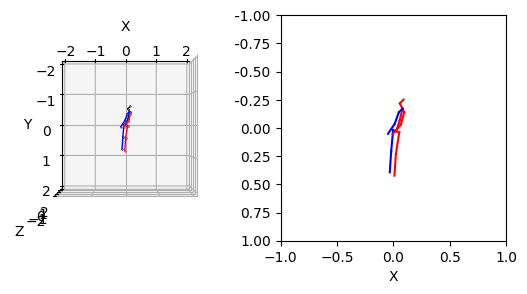

In [11]:
source = natsorted(list(set(datareader.dt_dataset['train']['source'])))[1]
target_frames = np.where(datareader.dt_dataset['train']['source'] == source)[0]
subject, cam_id, action = split_source_name(source, 'h36m')
cam_param = datareader.dt_dataset['test']['cam_param'][target_frames][0]
W, H, R, t, C, intrinsic, extrinsic = cam_param['W'], cam_param['H'], cam_param['R'], cam_param['t'], cam_param['C'], cam_param['intrinsic'], cam_param['extrinsic']

fig = plt.figure(0)
fig.clear()
ax_2d = axes_2d(fig, loc=122)
ax_3d = axes_3d(fig, loc=121, mode='cam')

pose3d = datareader.dt_dataset['train'][data_type_3d][target_frames].copy()
pose2d = datareader.dt_dataset['train'][data_type_2d][target_frames].copy()
pose2d_norm = normalize_input(pose2d, W, H)

ax_pose = [(ax_3d, pose3d), (ax_2d, pose2d_norm)]
save_path = os.path.join(save_folder, f'{subject}_{cam_id}_{action}.mp4')
generate_pose_video(fig, save_path, ax_pose, fps=5, stride=6, normalize_2d=True)

### Generate video from sliced data

In [4]:
checkpoint_name = 'MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_same_z_input_centering_steprot_1_tr_s1_ts_s5678'
args, opts = get_opt_args_from_model_name(checkpoint_name)
model_pos, chk_filename, checkpoint = load_model(opts, args)

subset = 'H36M-GT-CAM_NO_FACTOR-INPUT_FROM_3D_CANONICAL_SAME_Z-TR_S1_TS_S5678'
args.subset_list = [subset]
train_loader, test_loader, _, _, datareader = load_dataset(args, use_new_datareader=True)

configs/pose3d/MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_same_z_input_centering_steprot_1_tr_s1_ts_s5678.yaml
True
MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_same_z_input_centering_steprot_1_tr_s1_ts_s5678
Loading checkpoint checkpoint/pose3d/MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_same_z_input_centering_steprot_1_tr_s1_ts_s5678/best_epoch.bin
Loading dataset...
H36M-GT-CAM_NO_FACTOR-INPUT_FROM_3D_CANONICAL_SAME_Z-TR_S1_TS_S5678
[overwrite: False] ==> Loading H36M source_list...
[overwrite: False] ==> Loading H36M cam_param...
[overwrite: False] ==> Loading H36M cam_3d_same_z_steprot_1...
[overwrite: False] ==> Loading H36M img_2d_canonical_same_z_steprot_1...
[overwrite: False] ==> Loading H36M cam_3d_canonical_same_z_steprot_1...


In [6]:
datareader.input_mode

'joint_2d_from_canonical_3d'

In [15]:
trainset = datareader.dt_dataset['train'][datareader.input_mode][::datareader.sample_stride, :, :2]#.astype(np.float32)  # [N, 17, 2]
testset = datareader.dt_dataset['test'][datareader.input_mode][::datareader.sample_stride, :, :2]#.astype(np.float32)  # [N, 17, 2]
train_labels = datareader.dt_dataset['train'][datareader.gt_mode][::datareader.sample_stride, :, :3]#.astype(np.float32)  # [N, 17, 2]
test_labels = datareader.dt_dataset['test'][datareader.gt_mode][::datareader.sample_stride, :, :3]#.astype(np.float32)  # [N, 17, 2]
train_cam_param = datareader.dt_dataset['train']['cam_param'][::datareader.sample_stride]
test_cam_param = datareader.dt_dataset['test']['cam_param'][::datareader.sample_stride]
train_W, train_H = np.array([cam_param['W'] for cam_param in train_cam_param]), np.array([cam_param['H'] for cam_param in train_cam_param]) # (N,), (N,)
test_W, test_H = np.array([cam_param['W'] for cam_param in test_cam_param]), np.array([cam_param['H'] for cam_param in test_cam_param]) # (N,), (N,)
trainset.shape, testset.shape, train_labels.shape, test_labels.shape

((248376, 17, 2), (1311376, 17, 2), (248376, 17, 3), (1311376, 17, 3))

In [16]:
source = list(set(datareader.dt_dataset['test']['source']))[0]
print(source)
target_frames = np.where(datareader.dt_dataset['test']['source'] == source)[0]
subject, cam_id, action = split_source_name(source, 'h36m')

S6_55011271_Posing 2


In [17]:
testset[target_frames].shape, test_labels[target_frames].shape

((1159, 17, 2), (1159, 17, 3))

  0%|          | 0/194 [00:00<?, ?it/s]

100%|██████████| 194/194 [00:07<00:00, 26.60it/s]


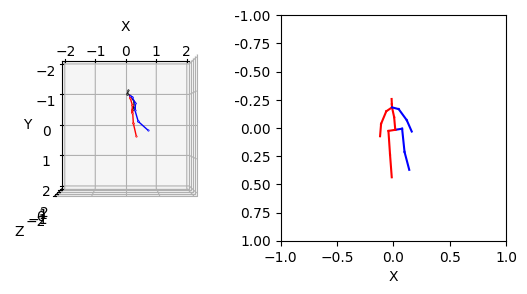

In [18]:
user = getpass.getuser()
save_folder = f'/home/{user}/codes/MotionBERT/videos/'
if not os.path.exists(save_folder): os.makedirs(save_folder)
save_path = os.path.join(save_folder, f'test4.mp4')

fig = plt.figure(0)
fig.clear()
ax_2d = axes_2d(fig, loc=122)
ax_3d = axes_3d(fig, loc=121, mode='cam')

#pose3d = train_labels[target_frames].copy()
#pose2d = trainset[target_frames][...,:2].copy()
pose3d = datareader.dt_dataset['test'][datareader.gt_mode][target_frames].copy()
pose2d = datareader.dt_dataset['test'][datareader.input_mode][target_frames][...,:2].copy()

pose2d_norm = normalize_input(pose2d, test_W[target_frames][0], test_H[target_frames][0])
ax_pose = [(ax_3d, pose3d), (ax_2d, pose2d_norm)]
generate_pose_video(fig, save_path, ax_pose, fps=5, stride=6, normalize_2d=True)

In [38]:
args.input_mode, args.gt_mode

('joint_2d_from_canonical_3d', 'cam_3d')

In [31]:
train_data, test_data = datareader.read_2d()     # train_data (1559752, 17, 3) test_data (566920, 17, 3)
train_labels, test_labels = datareader.read_3d() # train_labels (1559752, 17, 3) test_labels (566920, 17, 3)
split_id_train, split_id_test = datareader.get_split_id()

In [32]:
train_data.shape, test_data.shape, train_labels.shape, test_labels.shape

((248376, 17, 3), (1311376, 17, 3), (248376, 17, 3), (1311376, 17, 3))

In [35]:
source = list(set(datareader.dt_dataset['train']['source']))[3]
print(source)
target_frames = np.where(datareader.dt_dataset['train']['source'] == source)[0]
subject, cam_id, action = split_source_name(source, 'h36m')

S1_60457274_WalkTogether 1


In [36]:
train_data[target_frames].shape, train_labels[target_frames].shape

((1275, 17, 3), (1275, 17, 3))

100%|██████████| 213/213 [00:07<00:00, 27.36it/s]


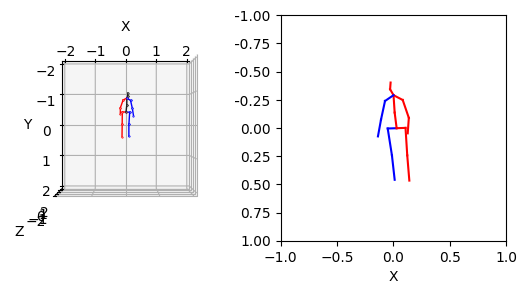

In [37]:
user = getpass.getuser()
save_folder = f'/home/{user}/codes/MotionBERT/videos/'
if not os.path.exists(save_folder): os.makedirs(save_folder)
save_path = os.path.join(save_folder, f'test2.mp4')

fig = plt.figure(0)
fig.clear()
ax_2d = axes_2d(fig, loc=122)
ax_3d = axes_3d(fig, loc=121, mode='cam')

pose3d = train_labels[target_frames].copy()
pose2d = train_data[target_frames][...,:2].copy()
ax_pose = [(ax_3d, pose3d), (ax_2d, pose2d)]
generate_pose_video(fig, save_path, ax_pose, fps=5, stride=6, normalize_2d=True)

100%|██████████| 41/41 [00:01<00:00, 22.70it/s]


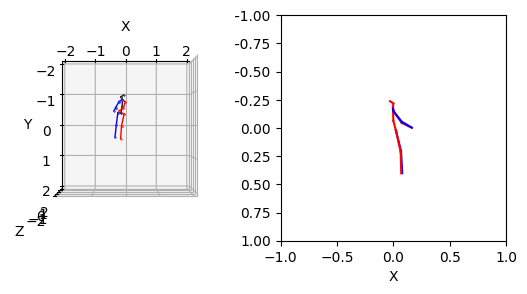

In [50]:
train_data, test_data, train_labels, test_labels = datareader.get_sliced_data()

user = getpass.getuser()
save_folder = f'/home/{user}/codes/MotionBERT/videos/input+gt/{checkpoint_name}/from_sliced_data/'
if not os.path.exists(save_folder): os.makedirs(save_folder)

for batch_num in range(len(train_labels)):
    pose3d = train_labels[batch_num].copy()
    pose2d = train_data[batch_num][...,:2].copy()
    
    fig = plt.figure(0)
    fig.clear()
    ax_2d = axes_2d(fig, loc=122)
    ax_3d = axes_3d(fig, loc=121, mode='cam')
    
    ax_pose = [(ax_3d, pose3d), (ax_2d, pose2d)]
    save_path = os.path.join(save_folder, f'train_batch{batch_num}.mp4')
    generate_pose_video(fig, save_path, ax_pose, fps=5, stride=6, normalize_2d=True)
    break

### Generate video from dataloader

In [19]:
checkpoint_name = 'MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_same_z_input_centering_steprot_1_tr_s1_ts_s5678'
args, opts = get_opt_args_from_model_name(checkpoint_name)
args.flip = False
model_pos, chk_filename, checkpoint = load_model(opts, args)

subset = 'H36M-GT-CAM_NO_FACTOR-INPUT_FROM_3D_CANONICAL_SAME_Z-STEP_ROT_1-TR_S1_TS_S5678'
args.subset_list = [subset]
train_loader, test_loader, _, _, datareader = load_dataset(args, use_new_datareader=True)

configs/pose3d/MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_same_z_input_centering_steprot_1_tr_s1_ts_s5678.yaml
True
MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_same_z_input_centering_steprot_1_tr_s1_ts_s5678
Loading checkpoint checkpoint/pose3d/MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_same_z_input_centering_steprot_1_tr_s1_ts_s5678/best_epoch.bin
Loading dataset...
H36M-GT-CAM_NO_FACTOR-INPUT_FROM_3D_CANONICAL_SAME_Z-STEP_ROT_1-TR_S1_TS_S5678
[overwrite: False] ==> Loading H36M source_list...
[overwrite: False] ==> Loading H36M cam_param...
[overwrite: False] ==> Loading H36M cam_3d_steprot_1...
[overwrite: False] ==> Loading H36M img_2d_canonical_same_z_steprot_1...
[overwrite: False] ==> Loading H36M cam_3d_canonical_same_z_steprot_1...


/home/hrai/codes/MotionBERT/videos/input+gt/MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_same_z_input_centering_steprot_1_tr_s1_ts_s5678/from_dataloader/test_batch0.mp4
/home/hrai/codes/MotionBERT/videos/input+gt/MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_same_z_input_centering_steprot_1_tr_s1_ts_s5678/from_dataloader/test_batch0.mp4 already exists
/home/hrai/codes/MotionBERT/videos/input+gt/MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_same_z_input_centering_steprot_1_tr_s1_ts_s5678/from_dataloader/test_batch1.mp4
/home/hrai/codes/MotionBERT/videos/input+gt/MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_same_z_input_centering_steprot_1_tr_s1_ts_s5678/from_dataloader/test_batch1.mp4 already exists
/home/hrai/codes/MotionBERT/videos/input+gt/MB_train_h36m_gt_cam_no_factor_input_from_canonical_3d_same_z_input_centering_steprot_1_tr_s1_ts_s5678/from_dataloader/test_batch2.mp4


100%|██████████| 41/41 [00:01<00:00, 21.75it/s]


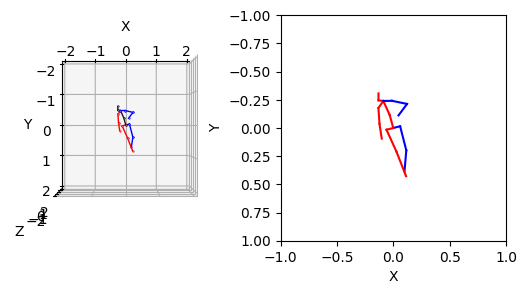

In [20]:
train_type = 'test'
if train_type == 'train': loader = train_loader
elif train_type == 'test': loader = test_loader
else: raise ValueError(f'Invalid train_type: {train_type}')

user = getpass.getuser()
save_folder = f'/home/{user}/codes/MotionBERT/videos/input+gt/{checkpoint_name}/from_dataloader'
if not os.path.exists(save_folder): os.makedirs(save_folder)

fig = plt.figure(0)
fig.clear()
ax_3d = axes_3d(fig, loc=121, mode='cam')
ax_2d = axes_2d(fig, loc=122)

for batch_num, (batch_input, batch_gt) in enumerate(loader):
    batch_input, batch_gt, batch_gt_torso, batch_gt_limb_pos = preprocess_eval(args, batch_input, batch_gt)
    save_path = os.path.join(save_folder, f'{train_type}_batch{batch_num}.mp4')
    print(save_path)
    if os.path.exists(save_path): 
        print(f'{save_path} already exists')
        continue
    #if batch_num == 2: break
    pose2d = batch_input[0].float().cpu().detach().numpy()[..., :2].copy()
    pose3d = batch_gt[0].float().cpu().detach().numpy().copy()
    ax_pose = [(ax_3d, pose3d), (ax_2d, pose2d)]
    generate_pose_video(fig, save_path, ax_pose, fps=5, stride=6, normalize_2d=True)
    break